In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

2024-04-25 21:40:15.827080: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load data
df = pd.read_csv('./Data/Merged Data/Modified/Automobile_mod.csv')

# Convert the date column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Setting the frequency of the Date index to Daily
#df.index.freq = 'D'

# Replace null values with 0
df.fillna(0, inplace=True)

# Print the data
print(df)

                Symbol Series  Prev Close     Open     High      Low     Last  \
Date                                                                            
2015-01-01  TATAMOTORS     EQ      495.55   494.50   499.45   492.25   498.55   
2015-01-02  TATAMOTORS     EQ      498.45   497.25   517.40   497.25   513.50   
2015-01-05  TATAMOTORS     EQ      511.80   510.10   526.00   506.70   524.10   
2015-01-06  TATAMOTORS     EQ      523.80   514.35   514.35   499.25   502.00   
2015-01-07  TATAMOTORS     EQ      501.40   495.00   500.40   489.20   493.70   
...                ...    ...         ...      ...      ...      ...      ...   
2021-04-26  BAJAJ-AUTO     EQ     3672.50  3682.20  3749.00  3676.00  3739.00   
2021-04-27  BAJAJ-AUTO     EQ     3738.85  3738.85  3798.00  3727.20  3795.00   
2021-04-28  BAJAJ-AUTO     EQ     3785.50  3810.05  3954.00  3807.00  3887.15   
2021-04-29  BAJAJ-AUTO     EQ     3889.75  3943.00  3954.30  3807.10  3818.95   
2021-04-30  BAJAJ-AUTO     E

In [5]:
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data.iloc[i:(i + sequence_length)].values
        y = data.iloc[i + sequence_length].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [4]:
def train_model_for_stock(stock_df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_df['Close'].values.reshape(-1,1))

    sequence_length = 60
    X, y = create_sequences(pd.DataFrame(scaled_data), sequence_length)

    # Split data into training and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build the LSTM model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, batch_size=32, epochs=20)

    # Calculate RMSE and MSE for training
    trainPredict = model.predict(X_train)
    trainScore_RMSE = sqrt(mean_squared_error(y_train, trainPredict))
    trainScore_MSE = mean_squared_error(y_train, trainPredict)
    trainScore_NRMSE = trainScore_RMSE / (scaler.inverse_transform(y_train).max() - scaler.inverse_transform(y_train).min())

    # Calculate RMSE and MSE for testing
    testPredict = model.predict(X_test)
    testScore_RMSE = sqrt(mean_squared_error(y_test, testPredict))
    testScore_MSE = mean_squared_error(y_test, testPredict)
    testScore_NRMSE = testScore_RMSE / (scaler.inverse_transform(y_test).max() - scaler.inverse_transform(y_test).min())

    return trainScore_RMSE, trainScore_MSE, trainScore_NRMSE, testScore_RMSE, testScore_MSE, testScore_NRMSE, scaler.inverse_transform(testPredict), y_test, scaler.inverse_transform(y_test)

In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd

def train_model_for_stock(stock_df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_df['Close'].values.reshape(-1,1))

    sequence_length = 60
    X, y = create_sequences(pd.DataFrame(scaled_data), sequence_length)

    # Split data into training and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build the LSTM model with regularization and dropout
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1), kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        LSTM(50, return_sequences=False, kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model with validation split for early stopping
    model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.2, callbacks=[early_stopping])

    # Calculate RMSE and MSE for training
    trainPredict = model.predict(X_train)
    trainScore_RMSE = sqrt(mean_squared_error(y_train, trainPredict))
    trainScore_MSE = mean_squared_error(y_train, trainPredict)
    trainScore_NRMSE = trainScore_RMSE / (scaler.inverse_transform(y_train).max() - scaler.inverse_transform(y_train).min())

    # Calculate RMSE and MSE for testing
    testPredict = model.predict(X_test)
    testScore_RMSE = sqrt(mean_squared_error(y_test, testPredict))
    testScore_MSE = mean_squared_error(y_test, testPredict)
    testScore_NRMSE = testScore_RMSE / (scaler.inverse_transform(y_test).max() - scaler.inverse_transform(y_test).min())

    return trainScore_RMSE, trainScore_MSE, trainScore_NRMSE, testScore_RMSE, testScore_MSE, testScore_NRMSE, scaler.inverse_transform(testPredict), y_test, scaler.inverse_transform(y_test)


In [9]:
def plot_predictions(stock_name, true_values, predictions):
    plt.figure(figsize=(14,7))
    plt.plot(true_values, label='Actual Close Price')
    plt.plot(predictions, label='Predicted Close Price', alpha=0.7)
    plt.title(f'{stock_name} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [11]:
# Create a DataFrame to store the RMSE and MSE values
# Columns: 'Stock', 'Train_RMSE', 'Train_MSE', 'Test_RMSE', 'Test_MSE'
performance_df = pd.DataFrame(columns=['Stock', 'Train_RMSE', 'Train_MSE', 'Train_NRMSE', 'Test_RMSE', 'Test_MSE', 'Test_NRMSE'])

Processing TATAMOTORS...


2024-04-25 21:41:27.997370: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-04-25 21:41:28.129459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 21:41:28.130186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 21:41:28.1

Epoch 1/20


2024-04-25 21:41:28.229635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 21:41:28.230567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 21:41:28.231121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

30/31 [============================>.] - ETA: 0s - loss: 0.7034

2024-04-25 21:41:32.143916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 21:41:32.144959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 21:41:32.145948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 4s 68ms/step - loss: 0.7028 - val_loss: 0.5046
Epoch 2/20
31/31 [==============================] - 2s 49ms/step - loss: 0.3892 - val_loss: 0.2862
Epoch 3/20
31/31 [==============================] - 2s 55ms/step - loss: 0.2241 - val_loss: 0.1626
Epoch 4/20
31/31 [==============================] - 2s 55ms/step - loss: 0.1302 - val_loss: 0.0943
Epoch 5/20
31/31 [==============================] - 2s 65ms/step - loss: 0.0784 - val_loss: 0.0568
Epoch 6/20
31/31 [==============================] - 2s 62ms/step - loss: 0.0494 - val_loss: 0.0364
Epoch 7/20
31/31 [==============================] - 2s 48ms/step - loss: 0.0338 - val_loss: 0.0248
Epoch 8/20
31/31 [==============================] - 2s 59ms/step - loss: 0.0249 - val_loss: 0.0178
Epoch 9/20
31/31 [==============================] - 2s 60ms/step - loss: 0.0196 - val_loss: 0.0141
Epoch 10/20
31/31 [==============================] - 1s 46ms/step - loss: 0.0151 - val_loss: 0.0116
Epoch 11/20
31/31 [=

2024-04-25 21:42:04.589969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 21:42:04.590988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 21:42:04.591625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 11ms/step


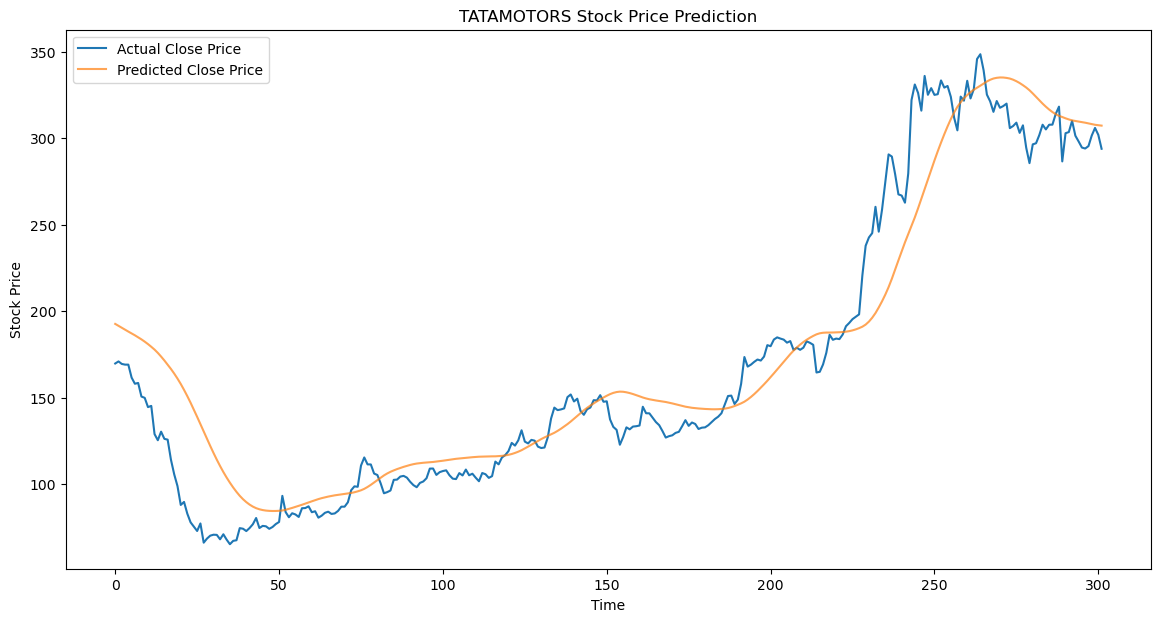

Processing EICHERMOT...
Epoch 1/20


2024-04-25 21:42:06.571314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 21:42:06.572034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 21:42:06.572639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - ETA: 0s - loss: 0.7401

2024-04-25 21:42:10.032694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 21:42:10.033784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 21:42:10.035277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 4s 74ms/step - loss: 0.7401 - val_loss: 0.5176
Epoch 2/20
31/31 [==============================] - 2s 55ms/step - loss: 0.4033 - val_loss: 0.2924
Epoch 3/20
31/31 [==============================] - 2s 60ms/step - loss: 0.2356 - val_loss: 0.1714
Epoch 4/20
31/31 [==============================] - 2s 50ms/step - loss: 0.1397 - val_loss: 0.1030
Epoch 5/20
31/31 [==============================] - 1s 42ms/step - loss: 0.0858 - val_loss: 0.0626
Epoch 6/20
31/31 [==============================] - 1s 43ms/step - loss: 0.0564 - val_loss: 0.0428
Epoch 7/20
31/31 [==============================] - 2s 59ms/step - loss: 0.0384 - val_loss: 0.0288
Epoch 8/20
31/31 [==============================] - 2s 48ms/step - loss: 0.0287 - val_loss: 0.0213
Epoch 9/20
31/31 [==============================] - 1s 48ms/step - loss: 0.0225 - val_loss: 0.0165
Epoch 10/20
31/31 [==============================] - 2s 60ms/step - loss: 0.0176 - val_loss: 0.0138
Epoch 11/20
31/31 [=

2024-04-25 21:42:41.780726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 21:42:41.781732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 21:42:41.782413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 14ms/step


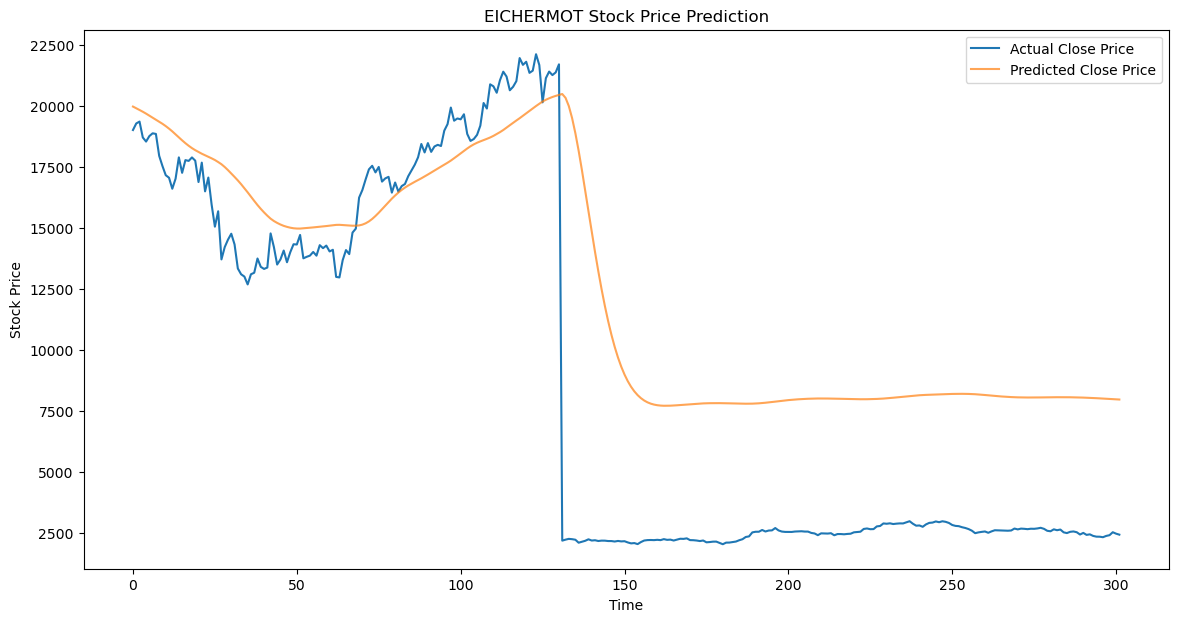

Processing HEROMOTOCO...
Epoch 1/20


2024-04-25 21:42:43.565820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 21:42:43.566365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 21:42:43.567062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - ETA: 0s - loss: 0.7088

2024-04-25 21:42:47.333276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 21:42:47.334435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 21:42:47.335396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 4s 75ms/step - loss: 0.7088 - val_loss: 0.5043
Epoch 2/20
31/31 [==============================] - 2s 54ms/step - loss: 0.3934 - val_loss: 0.2871
Epoch 3/20
31/31 [==============================] - 2s 59ms/step - loss: 0.2279 - val_loss: 0.1653
Epoch 4/20
31/31 [==============================] - 2s 54ms/step - loss: 0.1341 - val_loss: 0.0976
Epoch 5/20
31/31 [==============================] - 2s 53ms/step - loss: 0.0833 - val_loss: 0.0604
Epoch 6/20
31/31 [==============================] - 2s 53ms/step - loss: 0.0552 - val_loss: 0.0402
Epoch 7/20
31/31 [==============================] - 1s 40ms/step - loss: 0.0382 - val_loss: 0.0290
Epoch 8/20
31/31 [==============================] - 1s 46ms/step - loss: 0.0286 - val_loss: 0.0210
Epoch 9/20
31/31 [==============================] - 2s 74ms/step - loss: 0.0225 - val_loss: 0.0164
Epoch 10/20
31/31 [==============================] - 2s 50ms/step - loss: 0.0188 - val_loss: 0.0135
Epoch 11/20
31/31 [=

2024-04-25 21:43:19.767866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 21:43:19.769139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 21:43:19.769832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 19ms/step


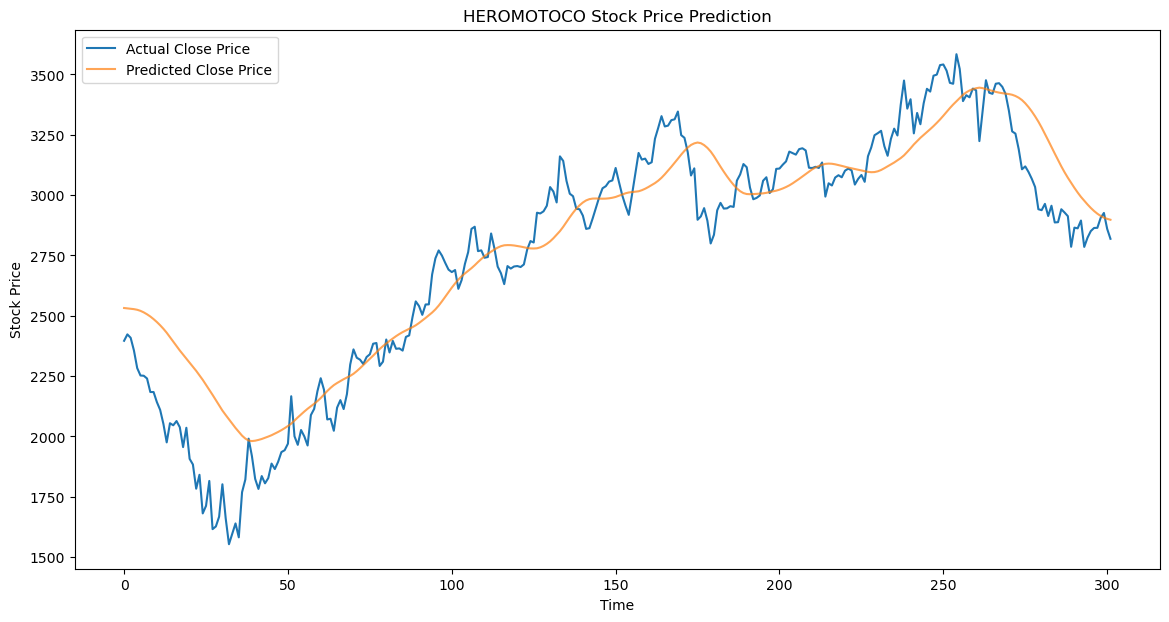

Processing MARUTI...
Epoch 1/20


2024-04-25 21:43:21.135967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 21:43:21.136518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 21:43:21.137121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

30/31 [============================>.] - ETA: 0s - loss: 0.7250

2024-04-25 21:43:24.352076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 21:43:24.353545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 21:43:24.354701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 4s 60ms/step - loss: 0.7243 - val_loss: 0.4928
Epoch 2/20
31/31 [==============================] - 1s 44ms/step - loss: 0.3889 - val_loss: 0.2835
Epoch 3/20
31/31 [==============================] - 2s 50ms/step - loss: 0.2237 - val_loss: 0.1638
Epoch 4/20
31/31 [==============================] - 2s 49ms/step - loss: 0.1322 - val_loss: 0.0973
Epoch 5/20
31/31 [==============================] - 2s 66ms/step - loss: 0.0797 - val_loss: 0.0601
Epoch 6/20
31/31 [==============================] - 2s 49ms/step - loss: 0.0519 - val_loss: 0.0407
Epoch 7/20
31/31 [==============================] - 2s 53ms/step - loss: 0.0357 - val_loss: 0.0286
Epoch 8/20
31/31 [==============================] - 2s 52ms/step - loss: 0.0272 - val_loss: 0.0224
Epoch 9/20
31/31 [==============================] - 2s 49ms/step - loss: 0.0205 - val_loss: 0.0163
Epoch 10/20
31/31 [==============================] - 1s 45ms/step - loss: 0.0161 - val_loss: 0.0134
Epoch 11/20
31/31 [=

2024-04-25 21:43:55.712084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 21:43:55.713149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 21:43:55.714033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 14ms/step


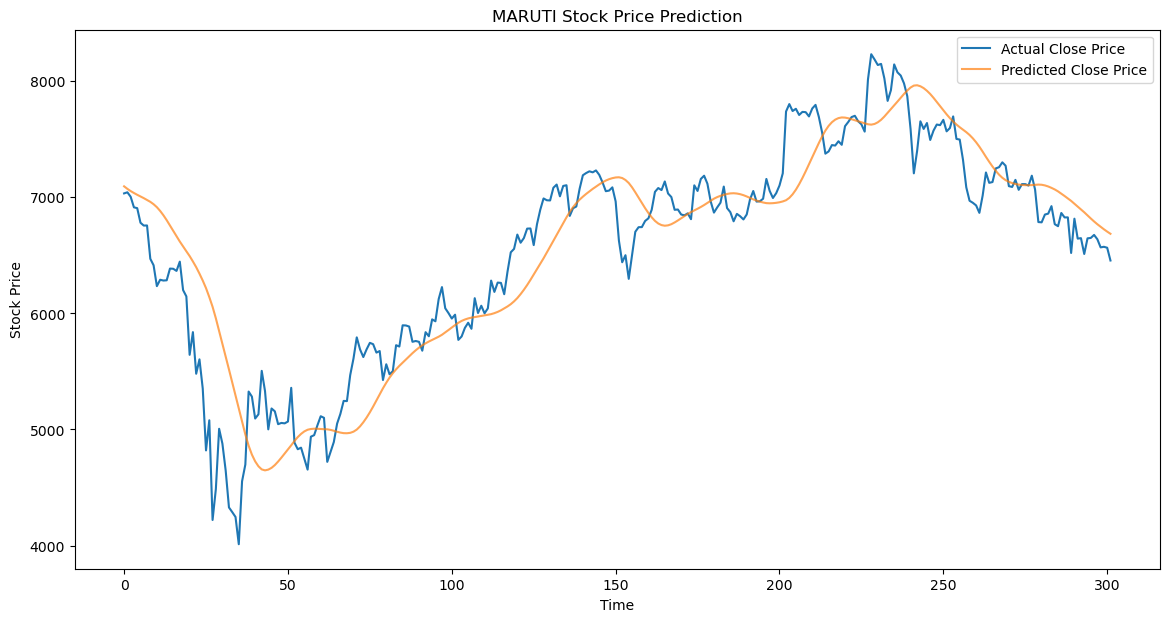

Processing M&M...
Epoch 1/20


2024-04-25 21:43:57.624395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 21:43:57.625065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 21:43:57.625533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

30/31 [============================>.] - ETA: 0s - loss: 0.7585

2024-04-25 21:44:01.335788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 21:44:01.336853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 21:44:01.337966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 4s 75ms/step - loss: 0.7577 - val_loss: 0.5262
Epoch 2/20
31/31 [==============================] - 2s 55ms/step - loss: 0.4122 - val_loss: 0.3124
Epoch 3/20
31/31 [==============================] - 2s 53ms/step - loss: 0.2468 - val_loss: 0.1880
Epoch 4/20
31/31 [==============================] - 2s 52ms/step - loss: 0.1510 - val_loss: 0.1135
Epoch 5/20
31/31 [==============================] - 2s 49ms/step - loss: 0.0975 - val_loss: 0.0734
Epoch 6/20
31/31 [==============================] - 1s 45ms/step - loss: 0.0652 - val_loss: 0.0502
Epoch 7/20
31/31 [==============================] - 1s 48ms/step - loss: 0.0473 - val_loss: 0.0355
Epoch 8/20
31/31 [==============================] - 2s 52ms/step - loss: 0.0364 - val_loss: 0.0286
Epoch 9/20
31/31 [==============================] - 2s 57ms/step - loss: 0.0283 - val_loss: 0.0202
Epoch 10/20
31/31 [==============================] - 2s 50ms/step - loss: 0.0270 - val_loss: 0.0241
Epoch 11/20
31/31 [=

2024-04-25 21:44:32.985079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 21:44:32.985975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 21:44:32.986783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 19ms/step


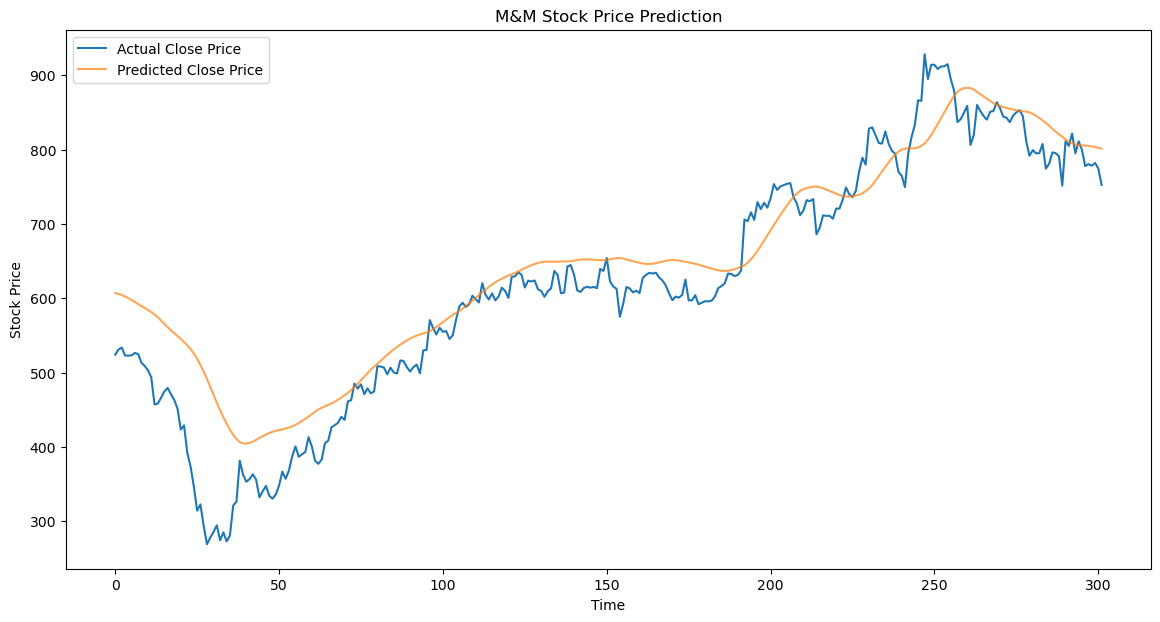

Processing BAJAJ-AUTO...
Epoch 1/20


2024-04-25 21:44:35.011714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 21:44:35.012551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 21:44:35.013081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

30/31 [============================>.] - ETA: 0s - loss: 0.6856

2024-04-25 21:44:38.877179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 21:44:38.878537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 21:44:38.879616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 4s 71ms/step - loss: 0.6850 - val_loss: 0.4824
Epoch 2/20
31/31 [==============================] - 2s 50ms/step - loss: 0.3669 - val_loss: 0.2586
Epoch 3/20
31/31 [==============================] - 2s 53ms/step - loss: 0.1959 - val_loss: 0.1367
Epoch 4/20
31/31 [==============================] - 2s 49ms/step - loss: 0.1032 - val_loss: 0.0734
Epoch 5/20
31/31 [==============================] - 1s 46ms/step - loss: 0.0549 - val_loss: 0.0381
Epoch 6/20
31/31 [==============================] - 1s 37ms/step - loss: 0.0299 - val_loss: 0.0215
Epoch 7/20
31/31 [==============================] - 2s 53ms/step - loss: 0.0176 - val_loss: 0.0138
Epoch 8/20
31/31 [==============================] - 2s 50ms/step - loss: 0.0115 - val_loss: 0.0093
Epoch 9/20
31/31 [==============================] - 1s 41ms/step - loss: 0.0086 - val_loss: 0.0108
Epoch 10/20
31/31 [==============================] - 2s 53ms/step - loss: 0.0073 - val_loss: 0.0059
Epoch 11/20
31/31 [=

2024-04-25 21:45:09.100785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 21:45:09.101968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 21:45:09.102913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 18ms/step


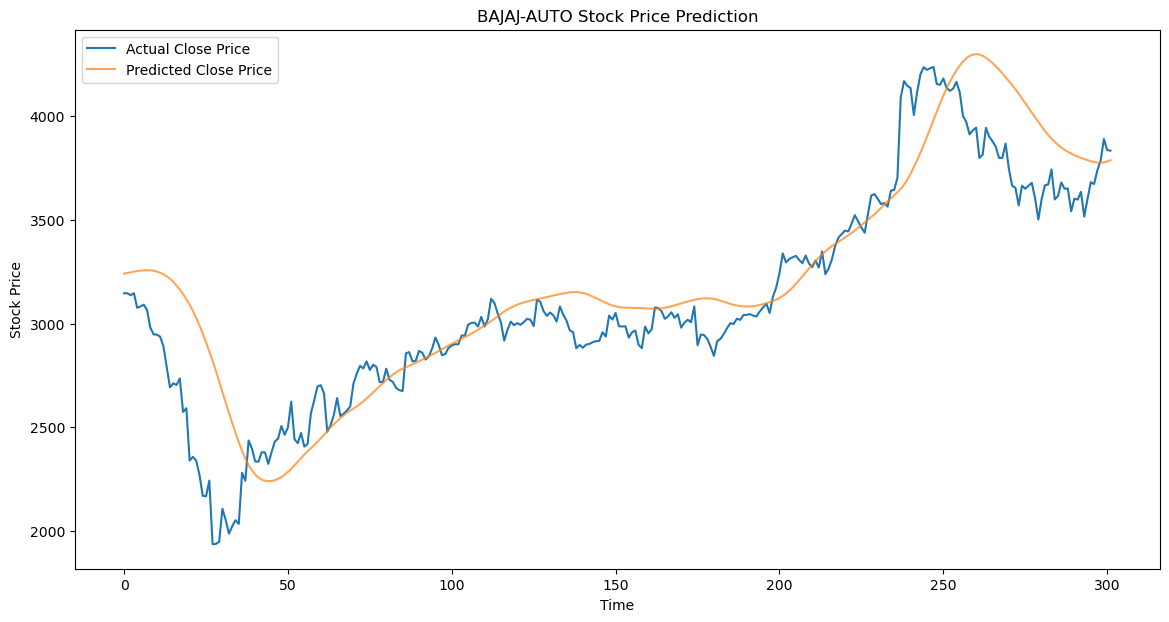

In [13]:
unique_stocks = df['Symbol'].unique()

# Initialize an empty list to store performance metrics for each stock
performance_list = []

for stock in unique_stocks:
    stock_df = df[df['Symbol'] == stock]
    if len(stock_df) > 2 * 60:  # Ensure there's enough data
        print(f"Processing {stock}...")
        trainScore_RMSE, trainScore_MSE, trainScore_NRMSE, testScore_RMSE, testScore_MSE, testScore_NRMSE, predictions, y_test, true_values = train_model_for_stock(stock_df)
        plot_predictions(stock, true_values, predictions)
        
        # Create a dictionary with the performance metrics
        current_stock_performance = {
            'Stock': stock,  # Replace with the actual stock name
            'Train_RMSE': trainScore_RMSE,
            'Train_MSE': trainScore_MSE,
            'Test_RMSE': testScore_RMSE,
            'Test_MSE': testScore_MSE,
            'Train_NRMSE': trainScore_NRMSE,
            'Test_NRMSE': testScore_NRMSE
        }
        
        # Append the dictionary to the list
        performance_list.append(current_stock_performance)

# Create a DataFrame from the list of dictionaries
performance_df = pd.DataFrame(performance_list)

# Now 'performance_df' contains the RMSE and MSE values for all stocks

In [15]:
performance_df

,Stock,Train_RMSE,Train_MSE,Test_RMSE,Test_MSE,Train_NRMSE,Test_NRMSE
0,TATAMOTORS,0.044597,0.001989,0.046473,0.002160,0.000093,0.000164
1,EICHERMOT,0.054332,0.002952,0.170290,0.028999,0.000003,0.000008
2,HEROMOTOCO,0.050269,0.002527,0.073435,0.005393,0.000028,0.000036
3,MARUTI,0.042649,0.001819,0.060757,0.003691,0.000006,0.000014
4,M&M,0.052765,0.002784,0.045861,0.002103,0.000050,0.000070
5,BAJAJ-AUTO,0.060867,0.003705,0.107980,0.011660,0.000042,0.000047
